In [1]:
import cv2
import numpy as np

def read_video(video_path):
    
    cap = cv2.VideoCapture(video_path)
    frames = []
    
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        
        frames.append(frame_rgb)
    
    cap.release()
    
    video = np.stack(frames, axis=0)
    return video

In [6]:
from model.GLUS import GLUSForCausalLM
import torch
from transformers import AutoTokenizer, BitsAndBytesConfig, CLIPImageProcessor
from sam2.utils.transforms import SAM2Transforms

# load model

def load_model(glus_version):

    tokenizer = AutoTokenizer.from_pretrained(
        glus_version,
        cache_dir=None,
        model_max_length=512,
        padding_side="right",
        use_fast=False,
    )
    tokenizer.pad_token = tokenizer.unk_token
    seg_token_idx = tokenizer("[SEG]", add_special_tokens=False).input_ids[0]
    
    torch_dtype = torch.bfloat16
    
    kwargs = {"torch_dtype": torch_dtype}
    kwargs.update(
        {
            "torch_dtype": torch.half,
            "quantization_config": BitsAndBytesConfig(
                llm_int8_skip_modules=["visual_model"],
                load_in_8bit=True,
            ),
            "not_use_mem_bank": False,
        }
    )
    
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    print(f'Using device: {device}')

    # model = GLUSForCausalLM.from_pretrained(
    #     glus_version, low_cpu_mem_usage=False, vision_tower="openai/clip-vit-large-patch14", seg_token_idx=seg_token_idx,
    #     sam_config="sam2_hiera_l.yaml", image_features_num=63, **kwargs
    # )
    model_config = {
        'vision_tower': "openai/clip-vit-large-patch14",
        'seg_token_idx': seg_token_idx,
        "sam_config": "sam2_hiera_l.yaml",
        "image_features_num": 63,
    }
    
    model = GLUSForCausalLM(model_config, **kwargs)
    
    model.config.eos_token_id = tokenizer.eos_token_id
    model.config.bos_token_id = tokenizer.bos_token_id
    model.config.pad_token_id = tokenizer.pad_token_id

    model.get_model().initialize_vision_modules(model.get_model().config)
    
    vision_tower = model.get_model().get_vision_tower()
    vision_tower.to(dtype=torch_dtype)
    model.to(torch_dtype).cuda()
    model.eval()
    
    clip_image_processor = CLIPImageProcessor.from_pretrained(model.config.vision_tower)
    transform = SAM2Transforms(224, mask_threshold=0.0)
    
    return model, clip_image_processor, transform, tokenizer, torch_dtype

In [3]:
from model.llava import conversation as conversation_lib
from utils.utils import (DEFAULT_IM_END_TOKEN, DEFAULT_IM_START_TOKEN,
                         DEFAULT_IMAGE_TOKEN, IMAGE_TOKEN_INDEX, CONTEXT_INFO_LIST, SHORT_QUESTION_LIST)
from model.llava.mm_utils import tokenizer_image_token

def inference_video(model, clip_image_processor, transform, tokenizer, images, target_obj, dtype):
    model.clear_mem_bank()
    conv = conversation_lib.conv_templates["llava_v1"].copy()
    conv.messages = []
    
    vid_len = len(images)
    context_frame_num = 4
    question_frame_num = 4
    i = 0
    
    masks_list = []
    full_images, full_images_clip = [], []
    
    for image_np in images:
        
        original_size_list = [image_np.shape[:2]]

        image_clip = (
            clip_image_processor.preprocess(image_np, return_tensors="pt")[
                "pixel_values"
            ][0]
        )
        image_clip = image_clip.to(dtype)

        image = transform(image_np).contiguous()
        resize_list = [image.shape[:2]]
        image = image.to(dtype)
        
        full_images.append(image)
        full_images_clip.append(image_clip)
        
    context_id = np.linspace(0, len(images)-1, num=4, dtype=int)
    context_frames = [full_images[id] for id in context_id]
    context_frames_clip = [full_images_clip[id] for id in context_id]
    
    while i < vid_len:
        i += 1
        
        images = context_frames + full_images[max(0, i-question_frame_num):i]
        images_clip = context_frames_clip + full_images_clip[max(0,i-question_frame_num):i]
        
        images = torch.stack(images, dim=0).unsqueeze(0).cuda()
        images_clip = torch.stack(images_clip, dim=0).unsqueeze(0).cuda()
        
        answer_prompt = "Sure, the segmentation result is "
        
        if i == 1:
            q_prompt = CONTEXT_INFO_LIST[0].format(class_name=target_obj.lower())
            q_prompt += SHORT_QUESTION_LIST[0].format(class_name=target_obj.lower())
        else:
            q_prompt = SHORT_QUESTION_LIST[0].format(class_name=target_obj.lower())
        replace_token = (
            DEFAULT_IM_START_TOKEN + DEFAULT_IMAGE_TOKEN + DEFAULT_IM_END_TOKEN
        )
        q_prompt = q_prompt.replace(DEFAULT_IMAGE_TOKEN, replace_token)
        conv.append_message(conv.roles[0], q_prompt)
        conv.append_message(conv.roles[1], answer_prompt)
            
        if i > question_frame_num:
            conv.messages = conv.messages[2:]
            q_prompt = CONTEXT_INFO_LIST[0].format(class_name=target_obj.lower())
            q_prompt += SHORT_QUESTION_LIST[0].format(class_name=target_obj.lower())
            replace_token = (
                DEFAULT_IM_START_TOKEN + DEFAULT_IMAGE_TOKEN + DEFAULT_IM_END_TOKEN
            )
            q_prompt = q_prompt.replace(DEFAULT_IMAGE_TOKEN, replace_token)
            conv.messages[0][-1] = q_prompt
                        
        prompt = "</s>".join(conv.get_prompt().split("</s>")[:-1])
        
        input_ids = tokenizer_image_token(prompt, tokenizer, return_tensors="pt")
        input_ids = input_ids.unsqueeze(0).cuda()
    
        output_ids, pred_masks, _ = model.evaluate(
            images_clip,
            images,
            input_ids,
            resize_list,
            original_size_list,
            rel_pos_list=list(range(max(0, i - question_frame_num), i)),
            mask_clips_list=None,
            max_new_tokens=1,
            tokenizer=tokenizer,
            context_frame_num=context_frame_num,
            question_frame_num=min(i, question_frame_num),
            mem_stride=3,
            decode_iter=True,
        )
        
        if pred_masks == None:
            print(f"Failed to generate image {i - 1} in current video. Auto-fill an [SEG] and while mask here.")
            conv.messages[-1][-1] += '[SEG] .'
            mask = torch.zeros(original_size_list[-1])
            masks_list.append(mask.unsqueeze(0))
            continue
        masks_list.append((pred_masks[-1][0] > 0).int())
        
        output_ids = output_ids[0][output_ids[0] != IMAGE_TOKEN_INDEX]
        text_output = tokenizer.decode(output_ids, skip_special_tokens=False).strip()
        text_output = text_output.replace("\n", "").replace("  ", " ")
        
        conv.messages[-1][-1] = text_output.split("ASSISTANT: ")[-1].split("</s>")[0] + '.'
        
    return masks_list
        

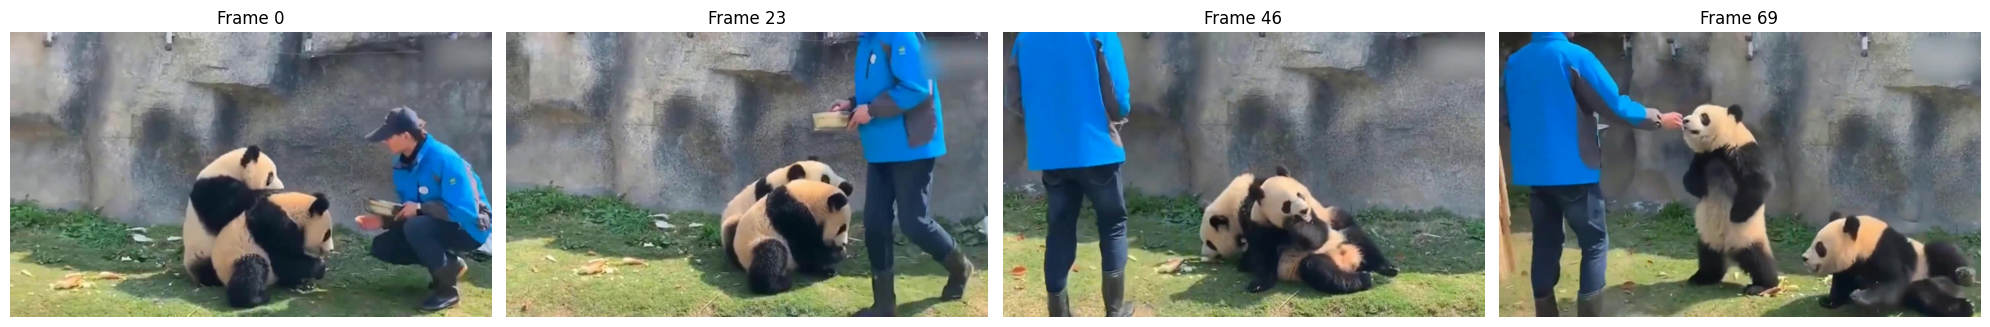

In [4]:
import matplotlib.pyplot as plt

# read video

frames = read_video(video_path="/scratch/bczp/llin5/data/tmp/video.mp4")

# show 4 frames

total_frames = len(frames)
indices = np.linspace(0, total_frames-1, num=4, dtype=int)
selected_frames = frames[indices]

fig, axes = plt.subplots(1, 4, figsize=(20, 5))

for i, (frame, ax) in enumerate(zip(selected_frames, axes)):
    ax.imshow(frame)
    ax.set_title(f"Frame {indices[i]}")
    ax.axis('off')

plt.tight_layout()
plt.show()

In [7]:
# get model

model, clip_image_processor, transform, tokenizer, torch_dtype = load_model(
    glus_version = '/work/nvme/bczp/llin5/ckpt/lisa_train/validation/sam2_full_data/5000step/model'
)

print(model)

Using device: cuda


AttributeError: 'dict' object has no attribute 'mm_use_im_start_end'